## Install dependencies
Here we install Openslide:
https://openslide.org/

This library allows us to load the whole-slide images

In [0]:
!apt-get install openslide-tools --assume-yes
!apt-get install python-openslide --assume-yes
!pip install --upgrade setuptools==45.3
!pip install openslide-python==1.1.1

## Helper Classes and functions


In [0]:
import os
import numpy as np
import openslide

from shapely.geometry import Polygon, MultiPolygon
from json import JSONEncoder, loads, dumps


class Slide:
    """Implements common functions to most of the standard slides. It is based
    on openslide.
    """

    def __init__(self, filename):
        self.path = filename
        self.slide = openslide.OpenSlide(filename)

    @property
    def file_name(self):
        return os.path.split(self.path)[1]

    @property
    def size(self):
        """Returns the size (width, height) in pixels of the maximum
        magnification level
        """
        return self.slide.level_dimensions[0]

    @property
    def level_count(self):
        """Returns the number of zoom levels"""
        return self.slide.level_count

    def get_downsample_factor(self, level):
        """Returns the downsample factor of a level. For example the 
        downsample factor of level 0 is always 1, level 1 is usually 2...
        """
        return self.slide.level_downsamples[level]

    def get_level_size(self, level):
        """Returns the size in pixels (width, height) of a specific level of
        the slide
        """
        return self.slide.level_dimensions[level]

    def get_patch(self, x, y, size, level):
        """Returns an RBG array of a rectangular region"""
        ds = self.get_downsample_factor(level)
        return np.array(self.slide.read_region(location=(int(ds * x), int(ds * y)),
                                               size=size,
                                               level=level).convert(
                                                   mode='RGB'))


class Annotation:
    """Represents a single annotation with a label and a sublabel"""

    def __init__(self, **kwargs):
        self.id = kwargs['id']
        self.name = kwargs['name']
        self.label = kwargs['label']
        self.sublabel = kwargs['sublabel']
        self.color = kwargs['color']
        self.points = kwargs['points']
        self.description = kwargs['description']

        pol = Polygon(self.points).buffer(0)
        self._polygon = pol

    @property
    def polygon(self):
        return self._polygon

    def plot(self):
        pols = []
        if isinstance(self.polygon, MultiPolygon):
            pols += list(self.polygon)
        else:
            pols = [self.polygon]
        for pol in pols:
            points = np.array(pol.exterior.coords)
            plt.plot(points[:,0], 1-points[:,1])


class Patch:
    """Class representing a rectangular region of a slide"""

    def __init__(self, slide, x, y, width, height, level):
        self.x, self.y = x, y
        self.width, self.height = width, height
        self.level = level
        self.slide = slide

        level_width, level_height = slide.get_level_size(level)
        
        rel_x = self.x / level_width
        rel_y = self.y / level_height
        rel_width = self.width / level_width
        rel_height = self.height / level_height

        self._polygon = Polygon.from_bounds(
            rel_x, 
            rel_y, 
            rel_x + rel_width, 
            rel_y + rel_height)

        self._internal_polygon = Polygon.from_bounds(
            rel_x + 0.25 * rel_width, 
            rel_y + 0.25 * rel_height, 
            rel_x + 0.75 * rel_width, 
            rel_y + 0.75 * rel_height)

    @property
    def polygon(self):
        return self._polygon

    @property
    def internal_polygon(self):
        return self._internal_polygon

    @property
    def size(self):
        return (self.width, self.height)

    def plot(self):
        points = np.array(self.polygon.exterior.coords)
        plt.plot(points[:,0], 1-points[:,1])

    def get_image(self):
        return self.slide.get_patch(self.x, self.y, self.size, self.level)

    def get_intersection(self, annotations):
        area = 0.0
        pol = Polygon()
        for annotation in annotations:
            pol = pol.union(annotation.polygon.intersection(self.polygon))
        return pol.area / self.polygon.area

    def get_internal_intersection(self, annotations):
        area = 0.0
        pol = Polygon()
        for annotation in annotations:
            pol = pol.union(annotation.polygon.intersection(self.internal_polygon))
        return pol.area / self.internal_polygon.area


class PatchIterable:
    """Iterable that returns patches around and inside regions defined 
    by a list of points
    
    Parameters
    ----------
    slide: Slide image
    regions: list of lists of points
    patch_size: size of the patches
    level: level where the patches should be extracted
    overlap: Overlap between consecutive patches. If None, it is assumed 
    to be (0,0)
    """
    def __init__(self, slide, regions, patch_size, level, overlap=None):
        self.slide = slide
        self.regions = regions
        self.patch_size = patch_size
        self.level = level
        self.overlap = overlap if overlap else (0, 0)
        self.dx, self.dy = (patch_size[0] - self.overlap[0], patch_size[1] - self.overlap[1])

    def __iter__(self):
        level_width, level_height = self.slide.get_level_size(self.level)
        patch_width, patch_height = self.patch_size

        for region in self.regions:
            # region is given in relative coordinates
            points = np.array([(int(x * level_width), int(y * level_height)) for (x, y) in region])
            region_pol = Polygon(region)

            xmin, ymin, xmax, ymax = np.infty, np.infty, -np.infty, -np.infty

            for x, y in points:
                xmin, xmax = min(xmin, x), max(xmax, x)
                ymin, ymax = min(ymin, y), max(ymax, y)

            xmin = max(0, xmin - patch_width)
            ymin = max(0, ymin - patch_height)
            xmax = min(xmax, level_width - patch_width + 1)
            ymax = min(ymax, level_height - patch_height + 1)

            for y in range(ymin, ymax, self.dy):
                for x in range(xmin, xmax, self.dx):
                    patch = Patch(self.slide, 
                                  x, y, 
                                  patch_width, 
                                  patch_height, 
                                  self.level)
                    
                    if region_pol.intersects(patch.polygon):
                        yield patch


def load_annotations(file_path):
    """Loads annotation from a JSON file"""
    with open(file_path, 'r') as f:
        annotations = loads(f.read())
        return list([Annotation(**m) for m in annotations])

## Load data and mount google drive

The dataset can be loaded into your Google Drive by using this link:
https://drive.google.com/open?id=1eDQJ-RXQHO52-1uP9d-zvz0FcmlufHBg




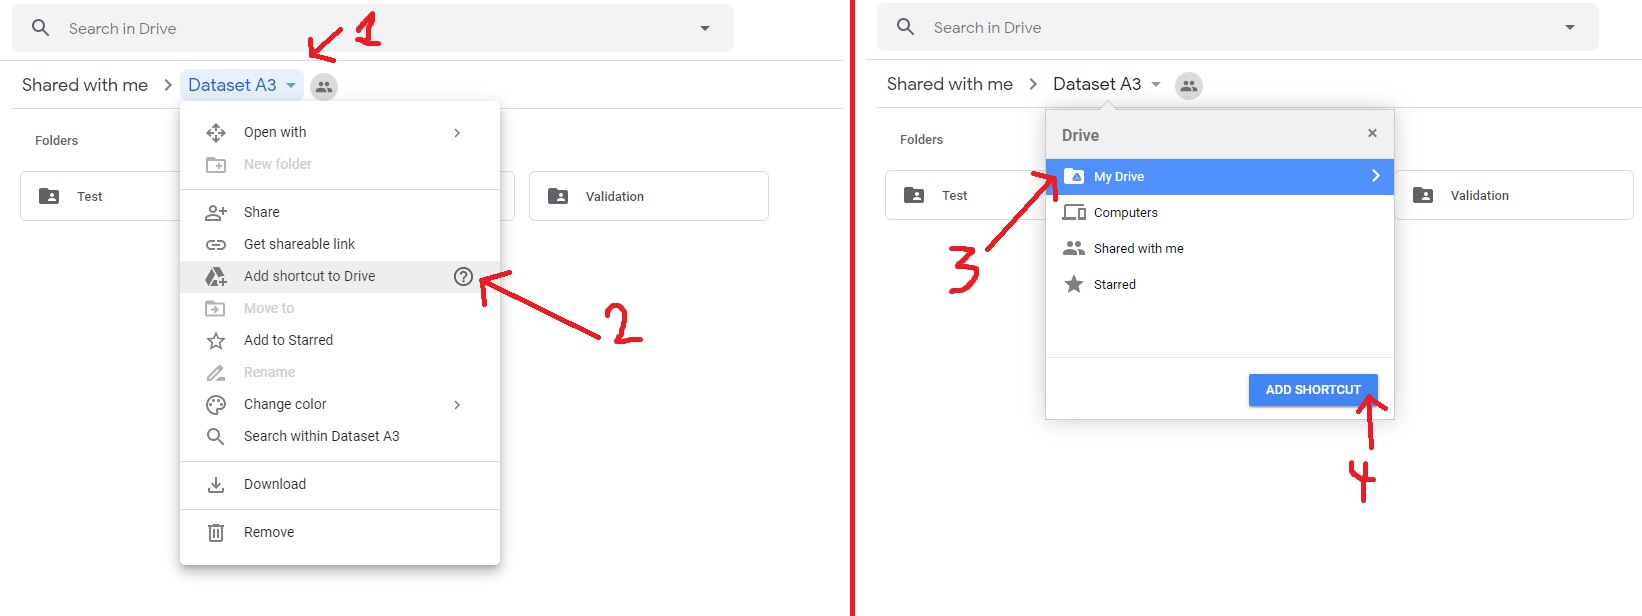

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

## Load and visualize slide
**Requirement:** Create a folder in the root of your Google Drive called `Results`

Whole slide images are stored in different resolution levels:

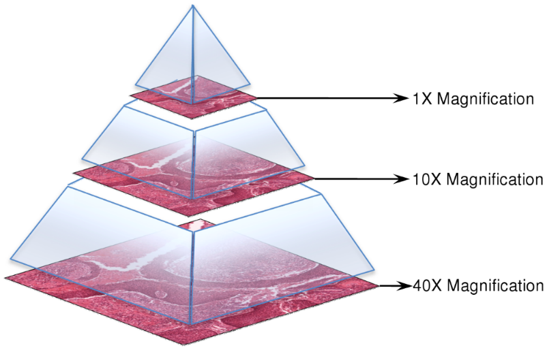


**Q1:** Load one of the whole slide-images  and visualize it at different levels

In [0]:
import os
import matplotlib.pyplot as plt


# these are the folders we will be using
results_path = "/content/drive/My Drive/Results"
train_path = "/content/drive/My Drive/Dataset A3/Train"
val_path = "/content/drive/My Drive/Dataset A3/Validation"
test_path = "/content/drive/My Drive/Dataset A3/Test"

# select one slide as an example for the data-processing pipeline
slide_path = os.path.join(train_path, 'patient01.ndpi')

##########################################
# TODO: 
# a) Load slide
# b) Print number of levels
# c) Select one level
# d) Print dimensions of the selected level
# e) Plot the image


##########################################

## Load annotations

**Q2:** Load the annotations and print the labels and the amount of points of each of them

In [5]:
annotation_path = slide_path.replace('.ndpi', '.json')

##########################################
# TODO: Write your code here


##########################################

Annotation: "Tumornest" with 133 points
Annotation: "Tumornest" with 63 points
Annotation: "Tumornest" with 597 points
Annotation: "Tumornest" with 109 points
Annotation: "Tumornest" with 550 points
Annotation: "Tumornest" with 608 points
Annotation: "Tumornest" with 67 points
Annotation: "Tumornest" with 313 points
Annotation: "Tumornest" with 78 points
Annotation: "Tumornest" with 307 points
Annotation: "Tumornest" with 222 points
Annotation: "Tumornest" with 268 points
Annotation: "Tumornest" with 167 points
Annotation: "Tumornest" with 505 points
Annotation: "Tumornest" with 174 points
Annotation: "Tumornest" with 125 points
Annotation: "Tumornest" with 300 points
Annotation: "Tumornest" with 262 points
Annotation: "Tumornest" with 231 points


## Extract Tissue
The firs step in the data preprocessing is to separate tissue from background.

**Q3**: Complete and run the following code. What happens? Can you improve the resulting mask?

In [0]:
import numpy as np
from skimage import color, filters, measure
from skimage.morphology import disk
from skimage.morphology import opening, closing


def extract_tissue(slide, level):
    """Get binary mask for the tissue region at a certain level"""

    width, height = slide.get_level_size(level)
    image = slide.get_patch(0, 0, (width, height), level)

    grey = color.rgb2grey(image)

    channel = 0
    thresh = filters.threshold_otsu(grey)
    mask = (grey > thresh).astype(np.uint8) * 255

    ##########################################
    # TODO: Apply opening and closing to improve the resulting mask
    


    ##########################################


    # creates polygons from the boundaries of the tissue mask
    contours = measure.find_contours(mask, 128)
    pols = []
    for c in contours:
        points = []
        for x, y in zip(c[:, 1], c[:, 0]):
            points.append((x / width, y / height))
        points.append(points[-1])
        pols.append(np.array(Polygon(points).exterior.coords))

    # returns the mask and the list of polygons
    return mask, pols



##########################################
# TODO: Call the above function for the previously loaded slide and plot 
# the resulting mask
level = slide.level_count - 3



##########################################

## Extract Patches

The next step in the pipeline is to extract patches from the image. 

**Q4:** Use the `PatchIterable` class, defined above to extract patches. Plot the tissue polygons and the extracted patches


In [0]:
patch_level = slide.level_count - 6
patch_size = (128, 128)

##########################################
# a) Create an instance of `PatchIterable` with the appropiate parameters 
# (hint: look at the definition in the section: "Helper Classes and functions")
# b) Plot the tissue polygons
# c) Iterate through the patches and use the `plot` function in the `Patch` class
# d) Print the total number of extracted patches 




##########################################

## Visualize patches
**Q5:** Visualize some of the extracted patches

In [0]:
##########################################
# TODO: Iterate through the first 10 patches. Obtain the image using the method 
# `get_image` from the `Patch` class and plot it



##########################################

## Extract patches with tumor

Now lets focus on the areas with tumor

**Q6:** Create a PatchIterable using the annotations instead of the tissue regions, extract the patches and plot them.

In [0]:
##########################################
# TODO:
# a) Create an instance of `PatchIterable` with the appropiate parameters 
# b) Plot the tissue polygons and plot the annotation polygons
# c) Iterate through the patches and use the `plot` function in the `Patch` class
# d) Print the total number of extracted patches 




##########################################

## Visualize patches with tumor
Now let's visualize some of the patches with tumor

**Q7**: Visualize the tumor patches

In [0]:
##########################################
# TODO: Iterate through the first 10 patches. Obtain the image using the method 
# `get_image` from the `Patch` class and plot it



##########################################

## Create Dataset

Let's put all together and create a dataset with patches from all the slides. We will create Pandas dataframe with all the information of the patches and then will save it to a .csv file.

In [12]:
import pandas as pd


def create_patches_dataset(slides_paths):
    """Creates a pandas Data Frame with all the patches extracted from
    the slides
    """

    data = []

    for slide_path in slides_paths:
        print(slide_path)
        slide = Slide(slide_path)
        annotations = load_annotations(slide_path.replace('.ndpi', '.json'))

        # use patch level 6 or 5 depending on the resolution of the image 
        # for tissue extraction
        _, polygons = extract_tissue(slide, slide.level_count - 3)

        # use patch level 3 or 2 depending on the resolution of the image 
        # for the patches
        patch_level = slide.level_count - 6

        sources = {'tissue': {'regions': polygons, 
                              'overlap': (64, 64)},
                   'tumor': {'regions': [annotation.points for annotation in annotations], 
                             'overlap': (96, 96)}}

        for (key, source) in sources.items():
            patches = PatchIterable(slide=slide, 
                                    regions=source['regions'],
                                    overlap=source['overlap'],
                                    patch_size=(128, 128),
                                    level=patch_level)
            for patch in patches:
                data.append([slide_path,
                             patch.level, 
                             patch.x, 
                             patch.y, 
                             patch.width, 
                             patch.height,
                             patch.get_intersection(annotations),
                             patch.get_internal_intersection(annotations),
                             key])
            
    df = pd.DataFrame(data=data, columns=['slide', 
                                          'level', 
                                          'x', 'y', 
                                          'width', 
                                          'height', 
                                          'tumor', 
                                          'internal-tumor',
                                          'source'])
    return df


train_slides = [os.path.join(train_path, 'patient0%d.ndpi' % i) for i in [1, 2, 3, 4, 5, 6, 7]]
val_slides = [os.path.join(val_path, 'patient0%d.ndpi' % i) for i in [8, 9]]
test_slides = [os.path.join(test_path, 'patient10.ndpi')]

for part, slides in [('train', train_slides), ('val', val_slides), ('test', test_slides)]:
    data = create_patches_dataset(slides)
    data.to_csv(os.path.join(results_path, f'{part}.csv'), index=False)

/content/drive/My Drive/Dataset A3/Train/patient01.ndpi
/content/drive/My Drive/Dataset A3/Train/patient02.ndpi
/content/drive/My Drive/Dataset A3/Train/patient03.ndpi
/content/drive/My Drive/Dataset A3/Train/patient04.ndpi
/content/drive/My Drive/Dataset A3/Train/patient05.ndpi
/content/drive/My Drive/Dataset A3/Train/patient06.ndpi
/content/drive/My Drive/Dataset A3/Train/patient07.ndpi
/content/drive/My Drive/Dataset A3/Validation/patient08.ndpi
/content/drive/My Drive/Dataset A3/Validation/patient09.ndpi
/content/drive/My Drive/Dataset A3/Test/patient10.ndpi


## Load dataset and visualize patches

**Q8:** Load dataset and visualize some patches. Try filtering patches by tumor area

In [0]:
##########################################
# TODO:
# a) Load the Pandas data frame using the `pd.read_csv` method
# b) Filter by patches with tumor area > 0.5
# c) Filter by patches with internal tumor area > 0
# d) Filter by patches with tumor area > 0.1 and internal tumor area = 0








##########################################